# 📦 Delivery Data Analysis Project
This project focuses on analyzing data from a delivery company. Using SQL and Python, we designed a database schema, imported data from a public Kaggle dataset, and created tables to organize the information. Through SQL queries executed from Python, we visualized key metrics such as delivery times, customer satisfaction, and order volumes. The analysis allowed us to identify trends and areas for improvement to optimize the company's operations. Our findings were compiled into a clear and accessible presentation.

### Metadata

**Authors**: [Lidia Mayor](https://www.linkedin.com/in/lidia-mayor-sanjuan-3b350930b/) and [Ana Nofuentes](https://www.linkedin.com/in/ana-nofuentes-solano-654026a3/)

**Data Source**: [🚚 Courier delivery service](https://kaggle.com/datasets/kapturovalexander/karpovs-sql-simulator?resource=download&select=orders.csv)

## Imports

In [2]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
import getpass  
import matplotlib.pyplot as plt
import seaborn as sns
from functions import *

In [3]:
password = getpass.getpass()

bd = "delivery"
connection_string = 'mysql+pymysql://root:' + password + '@localhost/' + bd
engine = create_engine(connection_string)

Prompts the user for a password, constructs a connection string for a MySQL database named "delivery" using that password, and creates a SQLAlchemy engine to connect to the database.

## Cancel rate

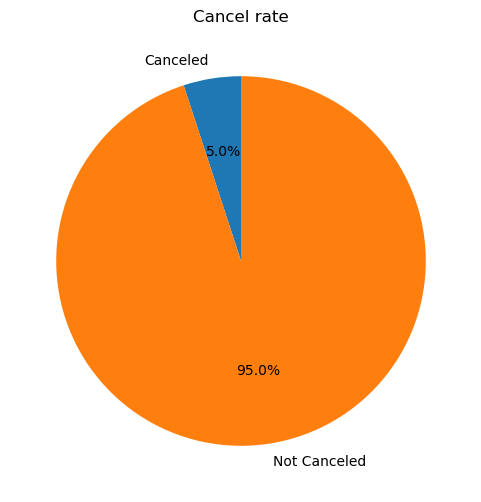

In [233]:
# Cancel rate
consulta1 = """
SELECT (SUM(CASE WHEN action = 'cancel_order' THEN 1 ELSE 0 END) / 
        COUNT(distinct(order_id))) * 100 AS cancel_rate 
FROM delivery.user_actions;
"""
df_cancel = pd.read_sql(consulta1, con=engine)

cancel_rate(df_cancel)

The order cancellation rate is 5%, and this has a significant impact on the company. It is a factor we must consider when establishing a minimum wait time before starting the logistics process for that order.

## Time to cancel the order

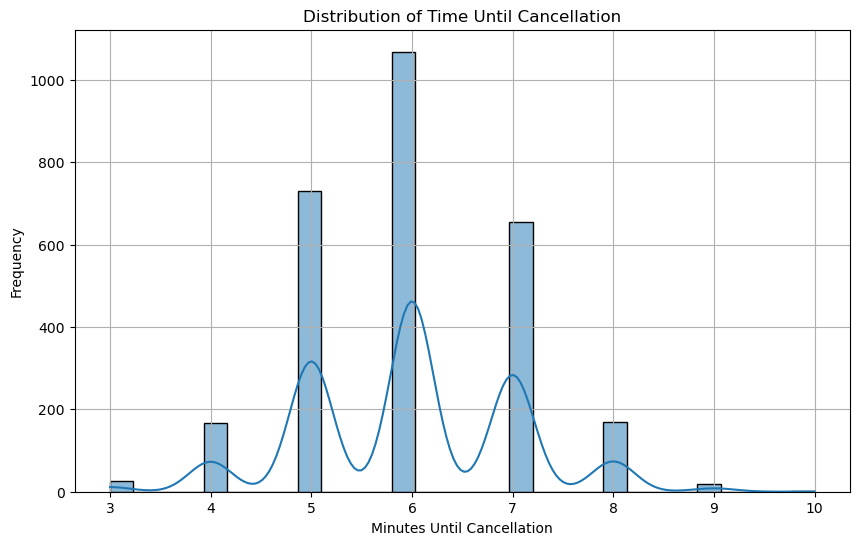

In [234]:
# Time to cancel the order
consulta2 = """
SELECT a.order_id, 
       TIMESTAMPDIFF(MINUTE, a.time, b.time) AS minute_to_cancel 
FROM delivery.user_actions a 
JOIN delivery.user_actions b ON a.order_id = b.order_id 
WHERE a.action = 'create_order' AND b.action = 'cancel_order';
"""
df_cancel_time = pd.read_sql(consulta2, con=engine)

cancel_time(df_cancel_time)

In [208]:
df_cancel_time['minute_to_cancel'].mean()

5.968639887244539

We measure the cancellation time in minutes, from when the order is placed until the moment of cancellation. A large majority of cancellations occur within the first 6 minutes.

## Average orders by age of users

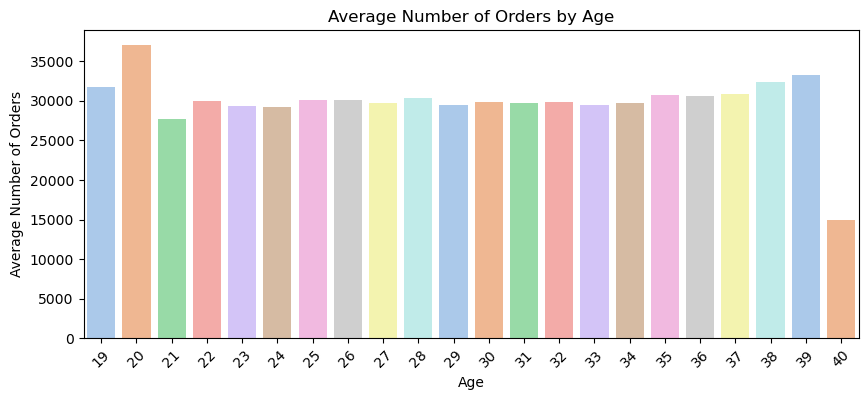

In [238]:
# Avg orders and genre
consulta3 = """
SELECT u.sex, TIMESTAMPDIFF(YEAR, u.birth_date, ua.time) AS age, 
       AVG(distinct(ua.order_id)) AS num_orders 
FROM delivery.users u 
JOIN delivery.user_actions ua ON u.user_id = ua.user_id 
GROUP BY u.sex, age;
"""
df_avg_order = pd.read_sql(consulta3, con=engine)

avg_order(df_avg_order)

We cannot perform a customer segmentation, as no significant differences are observed in the age sample we have obtained.

## Rate orders by genre

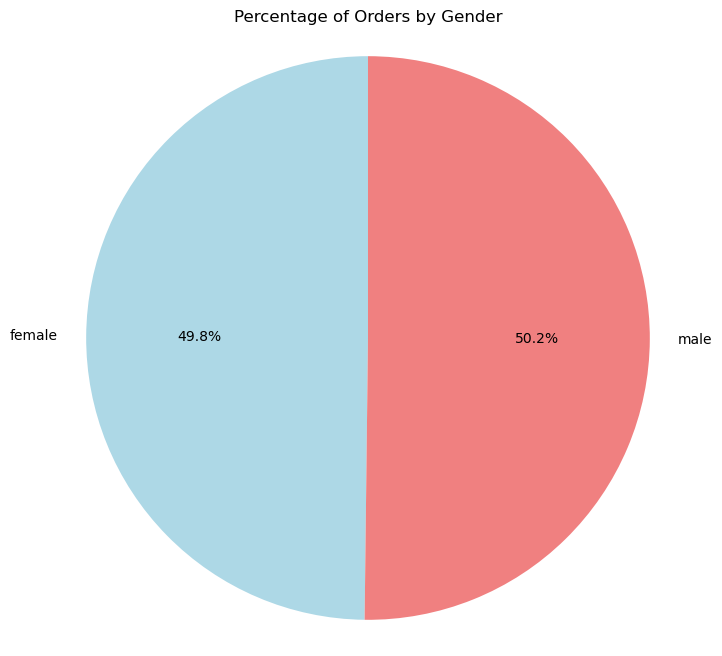

In [240]:
# Rate orders by genre
consulta4 = """
SELECT u.sex, 
       COUNT(distinct(ua.order_id)) AS total_orders 
FROM delivery.users u 
JOIN delivery.user_actions ua ON u.user_id = ua.user_id 
GROUP BY u.sex;
"""
df_rate_ord = pd.read_sql(consulta4, con=engine)

rate_ord(df_rate_ord)

The same applies to the gender variable, as both men and women place orders in the same proportion

## Total of couriers by age and genre

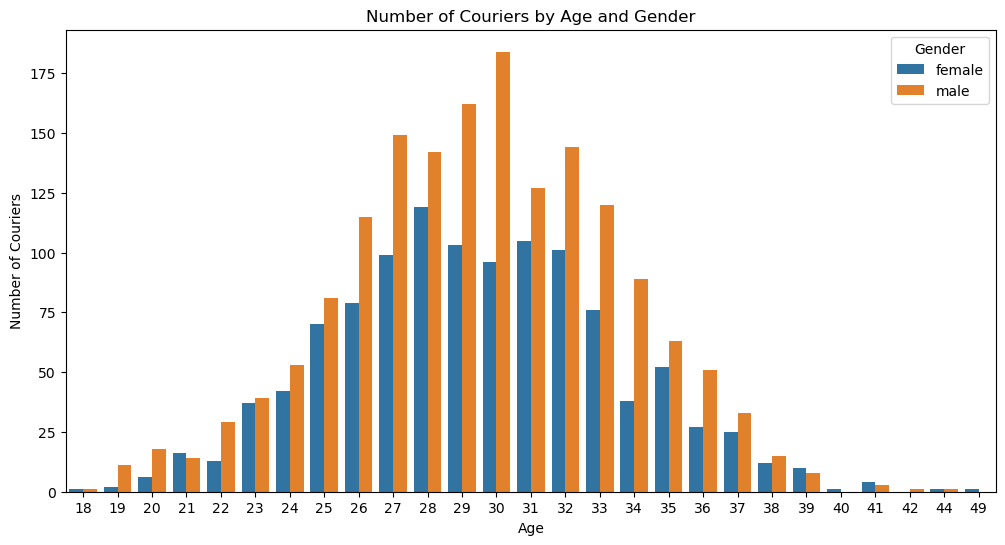

In [4]:
# Total of couriers by age and genre
consulta5 = """
SELECT c.sex, TIMESTAMPDIFF(YEAR, c.birth_date, NOW()) AS age, 
       COUNT(*) AS num_couriers 
FROM delivery.couriers c 
GROUP BY c.sex, age;
"""
df_couriers = pd.read_sql(consulta5, con=engine)

couriers(df_couriers)


The graph shows the distribution of couriers by age and gender. Most couriers are male, particularly between the ages of 29 and 35, where the number of male couriers is significantly higher compared to females. Women are also represented across various ages but in smaller numbers, with some exceptions, such as those aged 30 and 31. Additionally, there are some ages where the number of couriers is very low for both males and females.

## Avg delivery time by age and sex

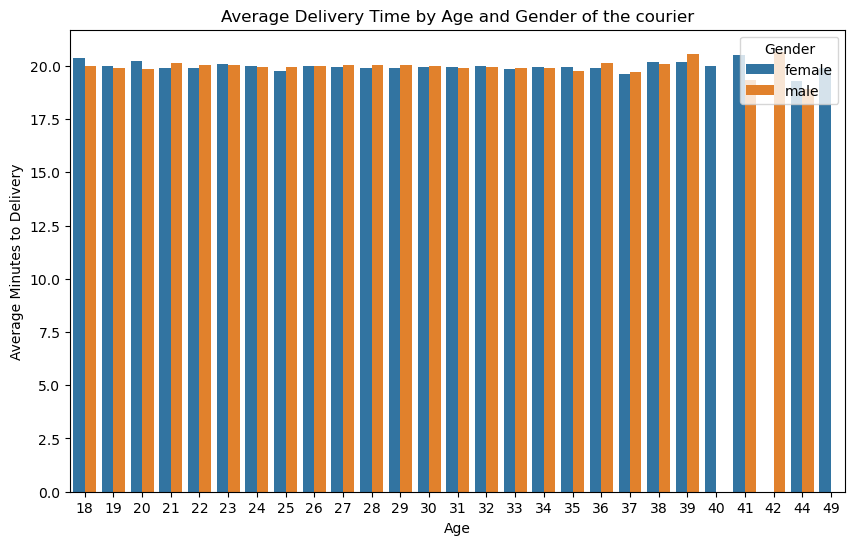

In [6]:
# Avg delivery time by age and sex
consulta6 = """
SELECT c.sex, TIMESTAMPDIFF(YEAR, c.birth_date, ca.time) AS age, 
       COUNT(distinct(ca.order_id)) AS num_orders, 
       AVG(TIMESTAMPDIFF(MINUTE, ca.time, b.time)) AS avg_minutes_to_delivery 
FROM delivery.couriers c 
JOIN delivery.courier_actions ca ON c.courier_id = ca.courier_id 
JOIN delivery.courier_actions b ON ca.order_id = b.order_id 
WHERE ca.action = 'accept_order' AND b.action = 'deliver_order' 
GROUP BY c.sex, age;
"""
df_avg_deliver = pd.read_sql(consulta6, con=engine)

avg_deliver(df_avg_deliver)

The graph shows the average delivery time by age and gender. Average delivery times remain relatively consistent across ages, averaging around 20 minutes.

## Total users vs total couriers

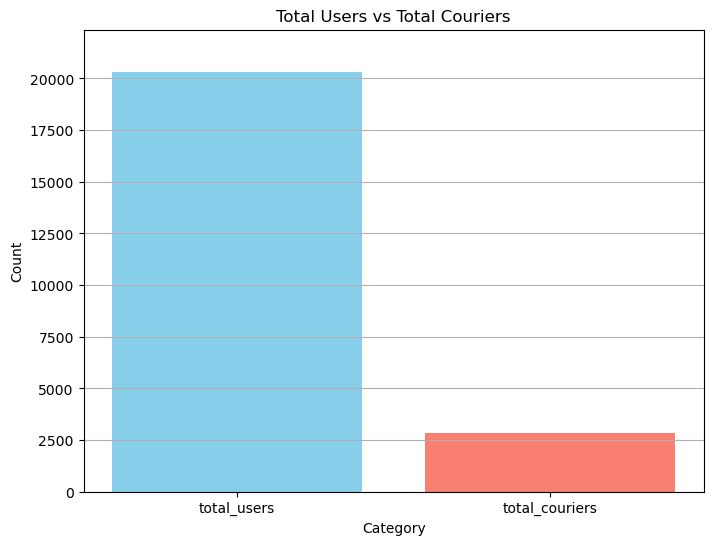

In [245]:
# Total users vs total couriers
consulta7 = """
SELECT (SELECT COUNT(*) FROM users) AS total_users, 
       (SELECT COUNT(*) FROM couriers) AS total_couriers;
"""
df_vs = pd.read_sql(consulta7, con=engine)

users_vs_couriers(df_vs)

In [246]:
users_per_courier = df_vs['total_users'][0] / df_vs['total_couriers'][0]

print(f'Each courier can serve an average of {users_per_courier:.2f} users.')

Each courier can serve an average of 7.20 users.


As we can see, the number of users is significantly greater than the number of couriers we have hired. If we want to reduce wait times to achieve greater user satisfaction, we propose hiring more couriers in the short term

## Total orders by day of the week and hour

In [251]:
# Total orders by day of the week and hour
consulta8 = """
SELECT DAYOFWEEK(creation_time) AS number_of_week, 
       DAYNAME(creation_time) AS day_of_week, 
       HOUR(creation_time) AS hour_of_day, 
       COUNT(order_id) AS total_orders 
FROM delivery.orders 
GROUP BY number_of_week, day_of_week, hour_of_day 
ORDER BY number_of_week, hour_of_day;
"""
df_order_by_time = pd.read_sql(consulta8, con=engine)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

We analyze peak days and peak hours to improve the distribution of couriers regarding scheduling, allowing us to create tailored shifts during times of high demand. This way, we can achieve shorter wait times and, in turn, a higher level of user satisfaction.

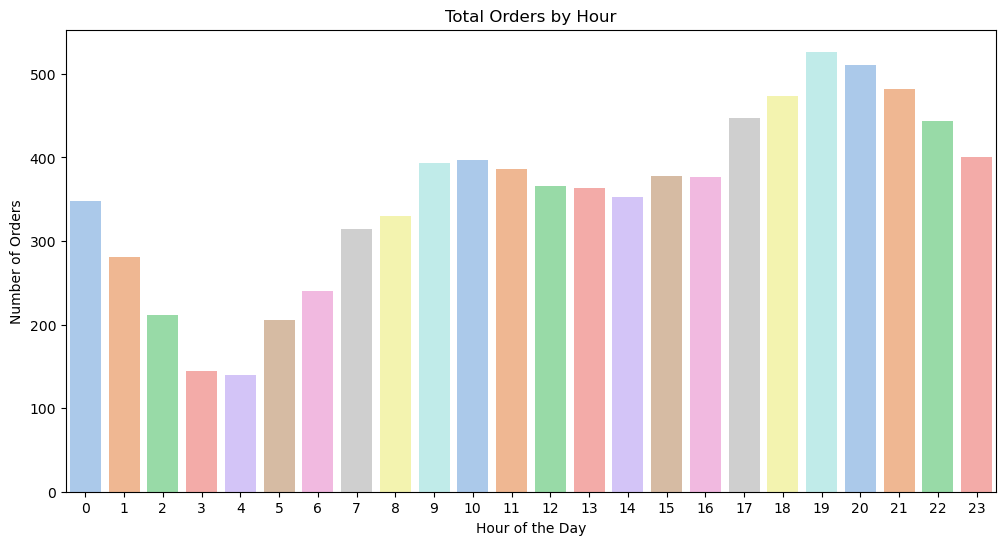

In [258]:
orders_by_hour(df_order_by_time)

regarding the hours there is a significant peak from 5 PM to 11 PM, with 7 PM being the peak hour.

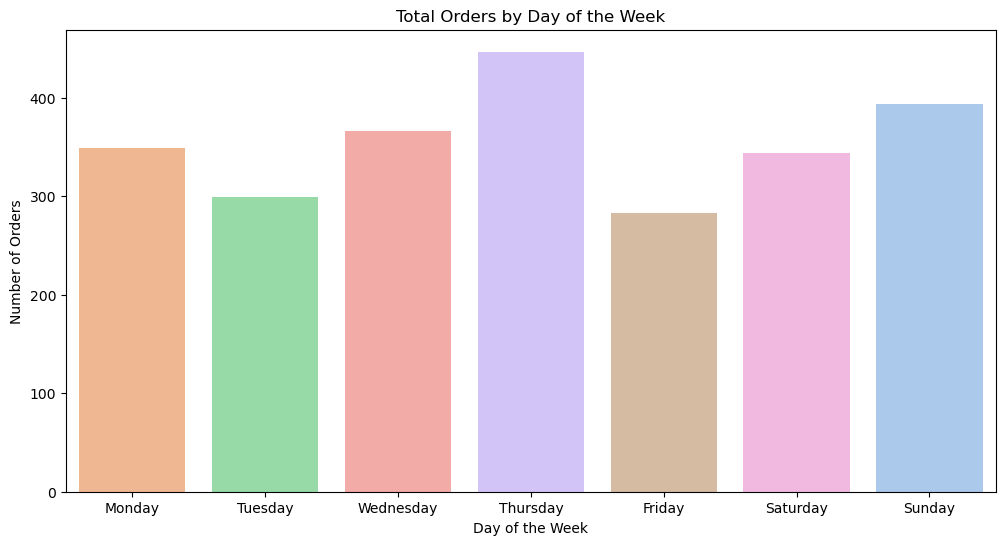

In [259]:
orders_by_day(df_order_by_time, day_order)

Thursdays, Sundays, and Mondays stand out.

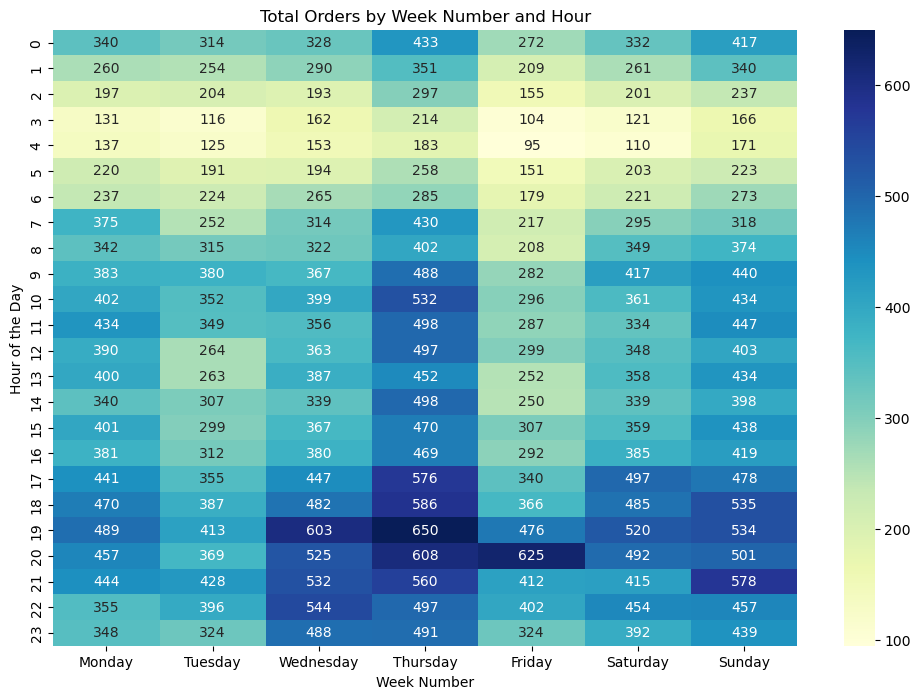

In [257]:
order_by_time(df_order_by_time, day_order)

Through this heatmap, we can see the relationship between both variables: day/time, where we observe that the peak hour of 7 PM coincides with the key day, which is Thursday.

Additionally, it helps us identify that Thursday, besides being the key day, shows consistently high demand for orders throughout the day, and that the afternoons of Wednesday, Friday, Saturday, and Sunday also experience a significant volume of orders.

## Conclusions

### Logistics Optimization

**Improvement**: Establish a minimum waiting time of 6 minutes before logistics.

**Economic Benefit**: Reduces operational costs by minimizing the impact of cancellations, optimizing resources, and avoiding unnecessary losses.

### Increase in Productivity

**Improvement**: Hire more couriers in the short term.

**Economic Benefit**: Reduces wait times and improves customer satisfaction, resulting in an increase in order volume and higher revenue.

### Homogeneous Strategies

**Improvement**: Implement improvements uniformly, without segmentation by age or gender.

**Economic Benefit**: Saves on marketing costs and simplifies operational planning, increasing efficiency in resource utilization.

### Redistribution in Key Hours

**Improvement**: Adjust resources during peak demand times (Thursdays and Wednesday to Sunday evenings).

**Economic Benefit**: Maximizes operational efficiency, avoids unnecessary costs, and enhances overall performance, contributing to an increase in profit margins.